## Lab 1

### Імплементація лінійної винагороди бездіяльності

+ Програмно реалізувати алгоритм лінійної винагороди-бездіяльності для навчання з підкріпленням (мова програмування - Java або Python). Проілюструвати, як за рахунок вибору швидкості навчання алгоритм за одних і тих самих умов може збігатися до оптимальної або неоптимальної стратегії

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output

### Середовище

+ для тестування оберемо середовище під назвою **Taxi-v3**

In [2]:
import gym
env = gym.make("Taxi-v3")

n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


Політика буде мати вигляд 2-вимірного масиву, оскільки в нашому середовищі існує скінченна кількість дій та станів:

`policy[s,a] = P(take action a | in state s)`

Створимо функцію для генерації сесій гри:

In [3]:
def generate_session(policy, t_max=int(10**4)):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    renders, states, actions, rewards, dones = [], [], [], [], []
    total_reward = 0.

    s = env.reset()
    renders.append(env.render(mode='ansi'))
    for _ in range(t_max):
        # sample action from policy
        a = np.random.choice(np.arange(n_actions), p=policy[s])

        new_s, r, done, info = env.step(a)

        # Record state, action and reward
        renders.append(env.render(mode='ansi'))
        states.append(s)
        actions.append(a)
        rewards.append(r)
        dones.append(done)
        total_reward += r

        s = new_s
        if done:
            break
    return renders, states, actions, rewards, dones, total_reward

Створимо функцію для оновлення політики:
+ будемо вважати що i-та дія прийшла до успіху, якщо агент зміг виконати завдання

In [4]:
def update_policy(policy, states, actions, dones, learning_rate):
    """
    Given old policy and a list of states/actions,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in states/actions]

    :param states: 1D list of states from sessions
    :param actions: 1D list of actions from sessions
    """

    # p_i = p_i + a * (1 - p_i)
    # p_j = p_j - a * p_j

    for idx in range(len(states)):
        p = policy[states[idx], actions[idx]]
        if dones[idx][-1]:
            policy[states[idx], actions[idx]] = p + learning_rate * (1 - p)
        else:
            policy[states[idx], actions[idx]] = p - learning_rate * p
    # віднормуємо ймовірності, що коректно працювала функція np.random.choice
    policy /= policy.sum(axis=1)[:, None]
        
    return policy

Також, додамо функцію для візуалізації процесу навчання:

In [5]:
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

Проведемо сесію навчання:

mean reward = -696.600, threshold=-722.000


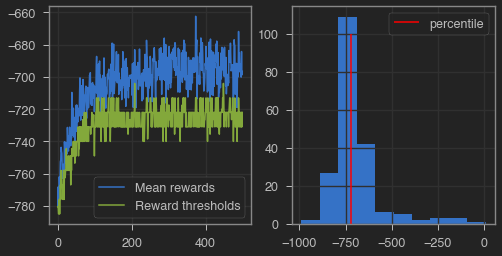

In [9]:
# sample this many sessions
n_sessions = 200
# take this percent of session with highest rewards
percentile = 50
# add this thing to all counts for stability
learning_rate = 0.001
# decay coeff for learning rate
decay_lr = 0.5

policy = np.full((n_states, n_actions), 1./n_actions)
log = []

for i in range(500):
    if (i+1) % 100 == 0:
        learning_rate *= decay_lr
    # generate new session
    sessions = [generate_session(policy) for _ in range(n_sessions)]
    _, states_batch, actions_batch, _, dones_batch, total_reward = zip(*sessions)

    # update policy
    policy = update_policy(policy, states_batch, actions_batch, dones_batch, learning_rate)

    # display results on chart
    show_progress(total_reward, log, percentile)

+ як ми бачимо з графіків вище, функція лінійної винагороди бездіяльності погано працює на даній задачі, хоча і спостерігається поступовий процес сходження
+ це можна пояснити тим, що вектор ймовірностей для кожного стану збігається до вектору, в якого лише одна компонента дорівнює 1, а решта мають нульові значення
+ тому для даної задачі краще використовувати інші функції оновлення політики

## Спробуємо іншу функцію оновлення політики

In [ ]:
def update_policy_2(policy, states, actions, learning_rate):
    """
    Given old policy and a list of states/actions,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in states/actions]

    :param states: 1D list of states from sessions
    :param actions: 1D list of actions from sessions
    """

    new_policy = np.zeros(policy_2.shape)

    for idx in range(len(states)):
        new_policy[states[idx], actions[idx]] += 1

    never_visited_states = new_policy.sum(axis=1) == 0
    new_policy[never_visited_states] = 1

    new_policy /= new_policy.sum(axis=1)[:, None]
    
    return learning_rate*new_policy + (1-learning_rate)*policy

mean reward = 1.107, threshold=3.500


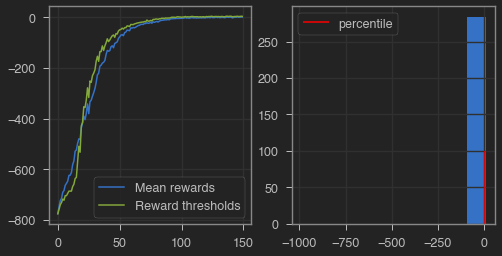

In [ ]:
# sample this many sessions
n_sessions = 200
# take this percent of session with highest rewards
percentile = 50
# add this thing to all counts for stability
learning_rate = 0.5
# decay coeff for learning rate
decay_lr = 0.5

policy_2 = np.full((n_states, n_actions), 1./n_actions)
log = []

for i in range(150):
    if (i+1) % 100 == 0:
        learning_rate *= decay_lr
    # generate new session
    sessions = [generate_session(policy_2) for _ in range(n_sessions)]
    _, states_batch, actions_batch, _, _, total_reward = zip(*sessions)

    # update policy
    policy_2 = update_policy_2(policy_2, states_batch, actions_batch, learning_rate)

    # display results on chart
    show_progress(total_reward, log, percentile)

In [ ]:
def render_replay(steps, delay=0.5):
    cum_reward = 0
    for step in steps:
        clear_output(wait=True)
        cum_reward += step[1]
        print("{} \nAction: {}\nReward: {}\nCumulative Reward: {}".format(step[0], step[2], step[1], cum_reward))
        time.sleep(delay)

In [ ]:
steps = []
steps.append([env.render(mode='ansi'), 0, "-"])
renders_batch, states_batch, actions_batch, rewards_batch, _, total_reward = generate_session(policy_2)
for render, state, action, reward in zip(renders_batch, states_batch, actions_batch, rewards_batch):
    steps.append([render, reward, action])

In [ ]:
render_replay(steps)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
 
Action: 5
Reward: 20
Cumulative Reward: -4
